In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
df = pd.read_csv('predictive_maintenance.csv')

In [65]:
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target', 'Failure Type'],
      dtype='object')

In [66]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


array([[<Axes: title={'center': 'UDI'}>,
        <Axes: title={'center': 'Air temperature [K]'}>,
        <Axes: title={'center': 'Process temperature [K]'}>],
       [<Axes: title={'center': 'Rotational speed [rpm]'}>,
        <Axes: title={'center': 'Torque [Nm]'}>,
        <Axes: title={'center': 'Tool wear [min]'}>],
       [<Axes: title={'center': 'Target'}>, <Axes: >, <Axes: >]],
      dtype=object)

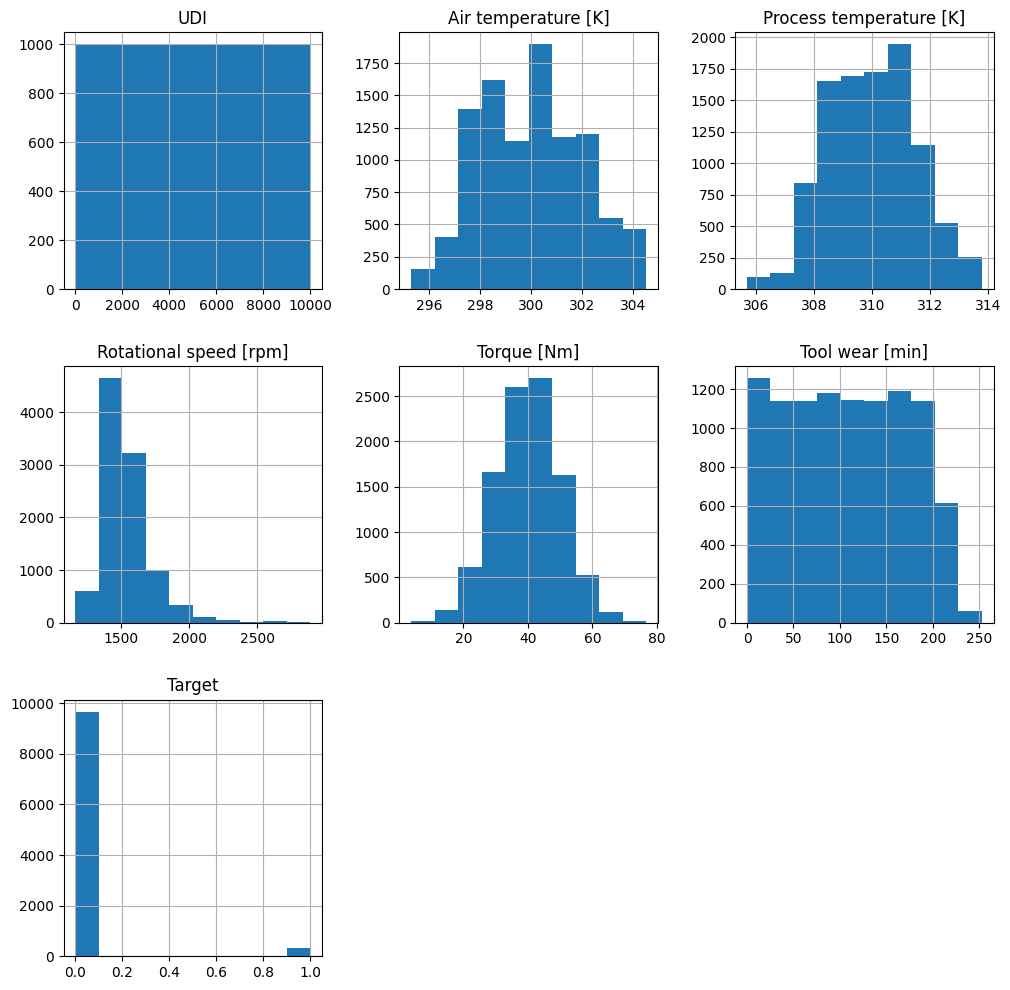

In [68]:
df.hist(figsize=(12,12))

In [69]:
df['Failure Type'].value_counts(normalize=True)

Failure Type
No Failure                  0.9652
Heat Dissipation Failure    0.0112
Power Failure               0.0095
Overstrain Failure          0.0078
Tool Wear Failure           0.0045
Random Failures             0.0018
Name: proportion, dtype: float64

In [70]:
## Data Preparation

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

X = df.drop(['UDI', 'Product ID', 'Target', 'Failure Type'], axis=1)  
y = df['Target']

numeric_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
categorical_features = ['Type']

In [71]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)])

X = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [72]:
## Model Building

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [73]:
rf = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [50, 100, 200],
    'max_depth' : [4, 6, 8, 10],
    'criterion' :['gini', 'entropy']}

In [74]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10],
                         'n_estimators': [50, 100, 200]})

In [75]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.3f}")

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 200}
Best score: 0.981


In [76]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1939
           1       0.85      0.48      0.61        61

    accuracy                           0.98      2000
   macro avg       0.92      0.74      0.80      2000
weighted avg       0.98      0.98      0.98      2000

[[1934    5]
 [  32   29]]


In [77]:
## Advanced Considerations

# Handle class imbalance
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [78]:
# Compare to XGBoost 
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=42)

xgb_param_grid = {
    'max_depth': [3,5,7],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': [50, 100, 200]}

xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=5)
xgb_grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]})

In [79]:
# Anomaly Detection
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(n_estimators=100, max_samples='auto', random_state=42)
isolation_forest.fit(X_train)

IsolationForest(random_state=42)

In [80]:
# Multi-class evaluation metrics
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
print(f"Precision for each class: {precision}")
print(f"Recall for each class: {recall}") 
print(f"F1 score for each class: {f1}")

Precision for each class: [0.9837233  0.85294118]
Recall for each class: [0.99742135 0.47540984]
F1 score for each class: [0.99052497 0.61052632]


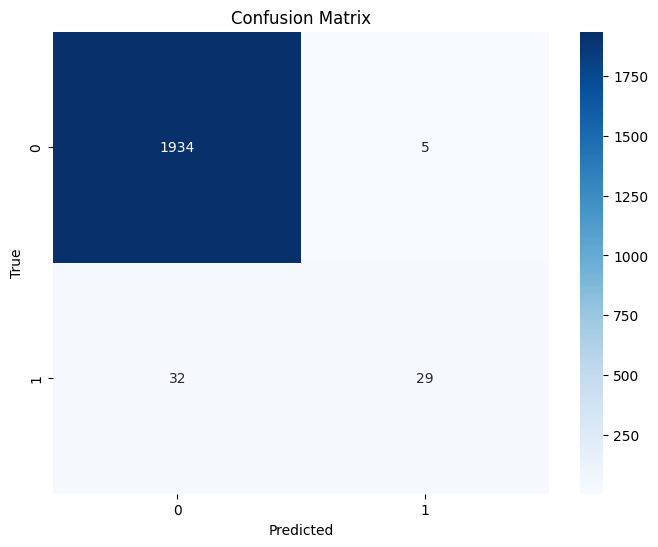

In [81]:
# Confusion matrix with labels
labels = sorted(y.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()